<a href="https://colab.research.google.com/github/nyleashraf/content-moderation-model/blob/master/content_moderation_model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Model Training: Introduction 

This project aims to utilize transfer learning to correctly identify images as either offensive, suggestive, or neutral. In this notebook, we utilize PyTorch to read in our image data, import a pre-trained ResNet model with custom fully-connected layers, and perform training, validation, and testing on our model. The overall goal of this project is to understand the challenges associated with the automation of content moderation and learn how to utilize transfer learning with PyTorch.

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip show torch

Name: torch
Version: 1.5.1+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.6/dist-packages
Requires: future, numpy
Required-by: torchvision, torchtext, fastai


In [ ]:
!pip show torchvision

Name: torchvision
Version: 0.6.1+cu101
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: torch, pillow, numpy
Required-by: fastai


In [ ]:
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Pre-Processing

In this section, we use the ImageFolder and Dataloader objects to read in our image files from their current directory and transform the files for use in the pre-trained Resnet-34 model.

In [ ]:
train_file_path = '/content/drive/My Drive/content-moderation-model/train'
test_file_path = '/content/drive/My Drive/content-moderation-model/test'

save_file_name = 'cmm-resnet34-transfer.pt'
checkpoint_path = 'cmm-resnet34-transfer.pth'

batch_size = 32

In [ ]:
# offensive_train_path = '/content/drive/My Drive/content-moderation-model/train/offensive'
# suggestive_train_path = '/content/drive/My Drive/content-moderation-model/train/suggestive'
# neutral_train_path = '/content/drive/My Drive/content-moderation-model/train/neutral'
# test_file_path = '/content/drive/My Drive/content-moderation-model/test'

# save_file_name = 'cmm-resnet34-transfer-balanced.pt'
# checkpoint_path = 'cmm-resnet34-transfer-balanced.pth'

# batch_size = 32

The following code block defines the pre-processing steps for each image file. First, we re-size the image to 256x256px, and then take a center crop with the size 224x224px, since the Resnet model architecture requires a 224x224px image input. Finally, we transform the images into tensors with 3 color channels and RGB values for each pixel.

In [ ]:
preprocess = transforms.Compose([
                         transforms.Resize(256),
                         transforms.CenterCrop(224),
                         transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_data = ImageFolder(train_file_path, transform = preprocess)
test_data = ImageFolder(test_file_path, transform = preprocess)

In [ ]:
# offensive_train_data = ImageFolder(offensive_train_path, transform=preprocess)
# suggestive_train_data = ImageFolder(suggestive_train_path, transform=preprocess)
# neutral_train_data = ImageFolder(neutral_train_path, transform=preprocess)
# test_data = ImageFolder(test_file_path, transform=preprocess)

After reading in the train and test directories into ImageFolder objects, we split the training folder into training and validation sets. In this case, we set aside 10% of our training data to use in our validation loop.

In [ ]:
# create validation set using random_split method
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

Now, we check to see if our pre-processing steps worked as expected...

*Expected tensor size: [3, 224, 224]*

In [ ]:
img, label = train_data[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[-0.5424, -0.6452, -0.6281,  ..., -0.8335, -0.4226, -0.5767],
         [-0.5767, -0.6281, -0.6281,  ..., -0.5253,  0.0227, -0.2684],
         [-0.5938, -0.5767, -0.6623,  ...,  0.0056,  0.2967, -0.0458],
         ...,
         [ 1.7523,  1.6838,  1.5468,  ..., -0.8164, -0.9020, -0.6623],
         [ 1.5468,  1.5468,  1.5639,  ...,  0.3309,  0.0912,  0.2282],
         [ 0.9988,  0.8961,  1.5468,  ...,  1.2043,  0.9646,  0.8104]],

        [[ 0.1702,  0.0651,  0.0651,  ..., -0.2850,  0.2402,  0.3978],
         [ 0.1001,  0.0301,  0.0301,  ...,  0.1702,  0.8004,  0.7654],
         [ 0.0476,  0.0651, -0.0224,  ...,  0.7479,  1.0980,  0.9055],
         ...,
         [ 2.0084,  1.9734,  1.8508,  ..., -0.1800, -0.1975,  0.1702],
         [ 1.9209,  1.9384,  1.8859,  ...,  0.9230,  0.7654,  1.0630],
         [ 1.5357,  1.4132,  1.9034,  ...,  1.7633,  1.6232,  1.5882]],

        [[ 1.0539,  0.9494,  0.9494,  ...,  0.3219,  0.8971,  1.0888],
         [ 0.9668,  0.9145,  0.9494,  ...,  0

...and if all our image files were read into the notebook.

*Expected output:*<br>
*Number of training images:  83699*<br>
*Number of validation images:  9300*<br>
*Number of test images:  6000*

In [ ]:
print("Number of training images: ", len(train_data))
print("Number of validation images: ", len(val_data))
print("Number of test images: ", len(test_data))

Number of training images:  83699
Number of validation images:  9300
Number of test images:  6000


In [ ]:
for image, label in train_data:
  print(image, label)
  break

tensor([[[-0.5424, -0.6452, -0.6281,  ..., -0.8335, -0.4226, -0.5767],
         [-0.5767, -0.6281, -0.6281,  ..., -0.5253,  0.0227, -0.2684],
         [-0.5938, -0.5767, -0.6623,  ...,  0.0056,  0.2967, -0.0458],
         ...,
         [ 1.7523,  1.6838,  1.5468,  ..., -0.8164, -0.9020, -0.6623],
         [ 1.5468,  1.5468,  1.5639,  ...,  0.3309,  0.0912,  0.2282],
         [ 0.9988,  0.8961,  1.5468,  ...,  1.2043,  0.9646,  0.8104]],

        [[ 0.1702,  0.0651,  0.0651,  ..., -0.2850,  0.2402,  0.3978],
         [ 0.1001,  0.0301,  0.0301,  ...,  0.1702,  0.8004,  0.7654],
         [ 0.0476,  0.0651, -0.0224,  ...,  0.7479,  1.0980,  0.9055],
         ...,
         [ 2.0084,  1.9734,  1.8508,  ..., -0.1800, -0.1975,  0.1702],
         [ 1.9209,  1.9384,  1.8859,  ...,  0.9230,  0.7654,  1.0630],
         [ 1.5357,  1.4132,  1.9034,  ...,  1.7633,  1.6232,  1.5882]],

        [[ 1.0539,  0.9494,  0.9494,  ...,  0.3219,  0.8971,  1.0888],
         [ 0.9668,  0.9145,  0.9494,  ...,  0

Now, we define a *show_example* function that allows us to visualize individual image files and display its label. 

In [ ]:
# function to display images in dataset 
def show_example(img, label):
    print('Label: ', test_data.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  neutral (0)


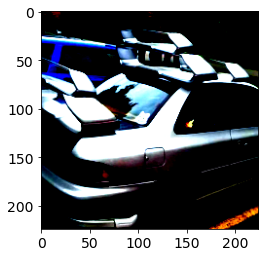

In [ ]:
show_example(*train_data[100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  neutral (0)


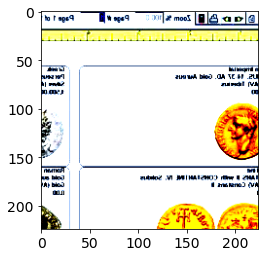

In [ ]:
show_example(*train_data[67897])

Finally, we convert our ImageFolder objects to Dataloader objects for use in our training, validation, and testing loops. 

In [ ]:
# add shuffle back in when training over entire dataset
num_train_samples = 10000
train_sample = np.random.randint(0,77360,num_train_samples)
# val_sample = np.random.randint(0,8596,num_samples)
# test_sample = np.random.randint(0,6000,num_samples)
# sampler=sampler.SubsetRandomSampler(train_sample)
dataloaders = {
    'train': DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2),
    'validation': DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2),
    'test': DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)
}

# Setting Up Model Architecture 

In this section, we read in a pre-trained model to utilize transfer learning to **hopefully** speed up our training times and increase our accuracy measures. Additionally, we define our training, validation, and testing loops in our *train* and *evaluate* functions. 

In *get_pretrained_model*, we pass in the model architecture we wish to use (functionality outlined in the docstring), freeze all the convolutional layers, and create custom fully-connected layers to reach our desired output of a size [1, 3] tensor that reflects the probability that a given image is each of the three outlined classes: offensive, suggestive, or neutral.

In [ ]:
n_classes = len(test_data.classes)

def get_pretrained_model(model_name):
  """Retrieve pre-trained model from torchvision.

    Params
    ------------
    model_name (str): name of pre-trained model (functionality for Resnet-50,
    vgg-16, and Resnet-34 model architectures)

    Return
    ------------
    PyTorch model
  """

  if model_name == 'resnet50':
    model = models.resnet50(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False
    
    n_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(n_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, n_classes),
        nn.LogSoftmax(dim=1)
    )
  
  elif model_name == 'vgg16':
    model = models.vgg16(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False
    
    n_inputs = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Linear(n_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, n_classes),
        nn.LogSoftmax(dim=1)
    )
  
  elif model_name == 'resnet34':
    model = models.resnet34(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False
    
    n_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(n_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, n_classes),
        nn.LogSoftmax(dim=1)
    )

  model.to('cuda')
  return model

Looking at the summary of our Resnet-34 model, we see all of the initialized convolutional layers, as well as our custom layers that follow. 

In [ ]:
model = get_pretrained_model('resnet34')
summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64

In [ ]:
print(model.fc)

Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=3, bias=True)
  (4): LogSoftmax()
)


In [ ]:
model.class_to_idx = test_data.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'neutral'), (1, 'offensive'), (2, 'suggestive')]

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 512])
torch.Size([256])
torch.Size([3, 256])
torch.Size([3])


In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          val_loader,
          save_file_name,
          max_epochs_stop=5,
          n_epochs=20,
          print_every=1,
          num_train_samples=50):
  
  epochs_no_improve = 0
  min_valid_loss = np.Inf

  max_val_acc = 0
  history = []

  overall_start = timer()

  for epoch in range(n_epochs):

    train_accuracy = 0
    validation_accuracy = 0

    train_loss = 0
    validation_loss = 0

    model.train()
    start = timer()

    for step, (data, label) in enumerate(train_loader):
      # move image and corresponding label to GPU for training
      data, label = data.cuda(), label.cuda()

      # clear gradients
      optimizer.zero_grad()
      # generate predicted label
      output = model(data)
      # print("Labels: ", label)

      # backpropogation 
      loss = criterion(output, label)
      loss.backward()

      # adjust weights and biases 
      optimizer.step()

      train_loss += loss.item() * data.size(0)

      # Calculate accuracy using NLL loss function 
      _, pred = torch.max(output, dim=1)
      # print("Predictions: ", pred)
      correct_tensor = pred.eq(label.data.view_as(pred))
      # print("Correct tensor: ", correct_tensor)
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
      # print("Training accuracy: ", accuracy)
      train_accuracy += accuracy.item() * data.size(0)

    print(f'Epoch: {epoch}\t{100 * (step + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.')
      
    # start validation step after training loops completion

    # model.epochs += 1

    with torch.no_grad():
      model.eval()

      for step, (data, label) in enumerate(val_loader):
        # move image and corresponding label to GPU for training
        data, label = data.cuda(), label.cuda()

        output = model(data)
        loss = criterion(output, label)
        validation_loss += loss.item() * data.size(0)

        # Calculate accuracy using NLL loss function
        # print("Output from model: ", output)
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(label.data.view_as(pred))
        # print("Predicted label: ", pred)
        # print("Actual label: ", label)
        # print(correct_tensor)
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        validation_accuracy += accuracy.item() * data.size(0)

      # Calculate average training and validation losses, accuracies
      train_loss = train_loss / len(train_loader.dataset)
      validation_loss = validation_loss / len(val_loader.dataset)
      train_accuracy = train_accuracy / len(train_loader.dataset)
      validation_accuracy = validation_accuracy / len(val_loader.dataset)
      # train_loss = train_loss / num_train_samples
      # validation_loss = validation_loss / num_samples
      # train_accuracy = train_accuracy / num_train_samples
      # validation_accuracy = validation_accuracy / num_samples

      history.append([train_loss, validation_loss, train_accuracy, validation_accuracy])

      if (epoch + 1) % print_every == 0:
        print(
              f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {validation_loss:.4f}'
              )
        print(
              f'\t\tTraining Accuracy: {100 * train_accuracy:.2f}%\t Validation Accuracy: {100 * validation_accuracy:.2f}%'
              )
      
      if validation_loss < min_valid_loss:
        # save model
        torch.save(model.state_dict(), save_file_name)
        # keep track of model improvements
        epochs_no_improve = 0
        min_valid_loss = validation_loss
        max_val_acc = validation_accuracy
        best_epoch = epoch
      
      else:
        epochs_no_improve += 1
        if epochs_no_improve >= max_epochs_stop:
          print(
                f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {min_valid_loss:.2f} and acc: {100 * max_val_acc:.2f}%'
                )
          total_time = timer() - overall_start
          print(
                f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                )
          
          model.load_state_dict(torch.load(save_file_name))
          model.optimizer = optimizer

          history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
          return model, history

  model.optimizer = optimizer
  total_time = timer() - overall_start
  print(
        f'\nBest epoch: {best_epoch} with loss: {min_valid_loss:.2f} and acc: {100 * max_val_acc:.2f}%'
        )
  print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
        )
    # Format history
  history = pd.DataFrame(
                    history,
                    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
  return model, history

In [ ]:
def save_checkpoint(model, path):
  """Saves all relevant model information to specified path.

    Params
    ------------
    model (PyTorch model): trained PyTorch model object, output from train() function
    path (str): name of .pth file, used for saving model and its attributes

    Return
    ------------
    none, saves model to specified path
  """
  # basic model details 
  checkpoint = {
    'class_to_idx': model.class_to_idx,
    'idx_to_class': model.idx_to_class,
    # 'epochs': model.epochs,
    }
  
  # saving model layers and weights
  checkpoint['fc'] = model.fc
  checkpoint['state_dict'] = model.state_dict()

  # saving model optimizer 
  checkpoint['optimizer'] = model.optimizer
  checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

  # save model to path
  torch.save(checkpoint, path)

In [ ]:
def load_checkpoint(path):
  """Loads all relevant model information from specified path.

    Params
    ------------
    path (str): name of .pth file, used for saving model and its attributes

    Return
    ------------
    none, saves model to specified path
  """

  checkpoint = torch.load(path)
  model = models.resnet34(pretrained=True)
  # freeze weights on all convolutional layers
  for param in model.parameters():
    param.requires_grad=False
  # add in fully-connected layers from checkpoint
  model.fc = checkpoint['fc']
  # add in other model attributes 
  model.class_to_idx = checkpoint['class_to_idx']
  model.idx_to_class = checkpoint['idx_to_class']
  # model.epochs = checkpoint['epochs']
  # move model to GPU
  model.to('cuda')
  # initialize model optimizer from checkpoint
  optimizer = checkpoint['optimizer']
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  return model, optimizer

In [ ]:
def evaluate(model,
             optimizer,
             criterion,
             test_loader,
             num_samples=None):
  """Loads all relevant model information from specified path.

    Params
    ------------
    path (str): name of .pth file, used for saving model and its attributes

    Return
    ------------
    none, saves model to specified path
  """
  test_loss = 0
  test_accuracy = 0
  # initialize dictionary to keep track of number of test samples of each class
  total_samples_dict = {0: 0, 1: 0, 2: 0}
  # initialize dictionary to keep track of number of correct predictions for each class
  total_correct_dict = {0: 0, 1: 0, 2: 0}

  model.eval()
  with torch.no_grad():
    for data, label in test_loader:
      # move batch to gpu
      data, label = data.to('cuda'), label.to('cuda')
      # generate predicted labels from the model
      out = model(data)
      loss = criterion(out, label)
      test_loss += loss.item() * data.size(0)

      _, pred = torch.max(out, dim=1)

      # update dictionaries to reflect total number of samples per class, total number of correct predictions per class
      for i in range(len(pred)):
        total_samples_dict[label[i].item()] += 1
        if pred[i] - label[i] == 0:
          total_correct_dict[label[i].item()] += 1

      correct_tensor = pred.eq(label.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
      test_accuracy += accuracy.item() * data.size(0)
    
  # test_loss = test_loss / num_samples
  # test_accuracy = test_accuracy / num_samples
  test_loss = test_loss / len(test_loader.dataset)
  test_accuracy = test_accuracy / len(test_loader.dataset)
  print(
        f'Testing Accuracy: {100 * test_accuracy:.2f}%\t Testing Loss: {test_loss:.4f}'
        )
  print(
      f"Accuracy per class: \n\tNeutral: {100 * total_correct_dict[0] / total_samples_dict[0]:.2f}%\tOffensive: {100 * total_correct_dict[1] / total_samples_dict[1]:.2f}%\tSuggestive: {100 * total_correct_dict[2] / total_samples_dict[2]:.2f}%"
      )
  print("Total samples dictionary: ", total_samples_dict)
  print("Total correct dictionary: ", total_correct_dict)

# Training and Evaluation

In this section, we use the functions defined in the prior section to train and evaluate our model. 

In [ ]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['validation'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=30,
    print_every=1,
    num_train_samples=num_train_samples)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97794746 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch: 0	100.00% complete. 31280.22 seconds elapsed in epoch.

Epoch: 0 	Training Loss: 0.2798 	Validation Loss: 0.2477
		Training Accuracy: 89.24%	 Validation Accuracy: 90.23%


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97794746 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 1	100.00% complete. 27016.38 seconds elapsed in epoch.

Epoch: 1 	Training Loss: 0.2385 	Validation Loss: 0.2090
		Training Accuracy: 90.88%	 Validation Accuracy: 91.92%


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [ ]:
# save_checkpoint(model, path = checkpoint_path)

In [ ]:
# model, optimizer = load_checkpoint(path = checkpoint_path)

In [ ]:
evaluate(model, 
         optimizer, 
         criterion, 
         dataloaders['test'], 
         num_samples)